In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from PIL import Image, ImageColor

In [3]:
parts = {1: {'col': 'orange', 'name':'hood'},
         2: {'col':'darkgreen', 'name':'front door'},
         3: {'col':'yellow', 'name':'rear door'},
         4: {'col':'cyan', 'name':'frame'},
         5: {'col':'purple', 'name':'rear quarter panel'},
         6: {'col':'lightgreen', 'name':'trunk lid'},
         7: {'col':'blue', 'name':'fender'},
         8: {'col':'pink', 'name':'bumper'},
         9: {'col':'darkgray', 'name':'rest of car'},
         0 : {'col':'black', 'name':'background'}}

def display_car(data_arr):
    # Can take both full data and already split data
    if data_arr.shape[2] > 3: data_arr = data_arr[:,:,:3]
    img = Image.fromarray(data_arr)
    display(img) # img.show() for jupyter

def display_labels(data_arr):
    # Can take both full data and already split data
    if data_arr.ndim > 2: data_arr = data_arr[:,:,3]
    img = Image.fromarray(data_arr)
    pixels = list(img.getdata())
    pixels = [ImageColor.getrgb(parts.get(pixel)['col']) for pixel in pixels]
    image = Image.new("RGB", (256, 256), (0,0,0))
    image.putdata(pixels)
    display(image)


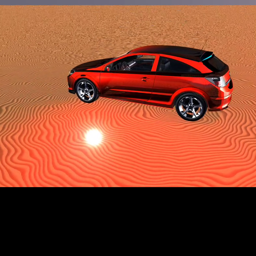

In [4]:
arr = np.load('/content/drive/MyDrive/carseg_data/arrays/orange_3_doors_0101.npy')
display_car(arr)
#display_labels(arr)

In [5]:
def change_indices(labels):
  for label in labels:
    for i in range(len(label)):
      if label[i] != 0:
        label[i] = label[i] // 10
  return labels

In [6]:
import os
import numpy as np
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.filenames = os.listdir(self.root)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        arr = np.load(os.path.join(self.root, filename))
        car = arr[:,:,0:3]
        labels = change_indices( arr[:,:,3])
        #labels = arr[:,:,3]

        return car, labels

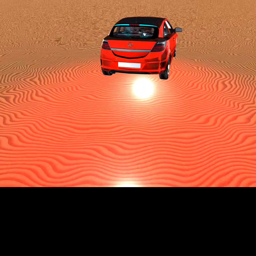

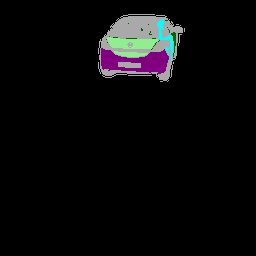

In [7]:
ds = CarDataset('/content/drive/My Drive/carseg_data/arrays')
car, labels = ds[1000]
display_car(car)
display_labels(labels)

In [8]:
end = len(ds)*80//100

In [9]:
from torch.utils.data import DataLoader, Subset

sub_ind = list(range(end))
train_subset = Subset(ds, sub_ind)

train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([16, 256, 256, 3])
Labels batch shape: torch.Size([16, 256, 256])


In [10]:
sub_ind_val = list(range(end, len(ds)))
val_subset = Subset(ds, sub_ind_val)

valid_dataloader = DataLoader(val_subset, batch_size=16, shuffle=True)

In [11]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
unet = UNet(3, 91)

In [14]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

LEARNING_RATE = 0.001
loss = CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, weight_decay=0.0002)


In [17]:
import torch.nn.functional as F
from torchmetrics.classification import Dice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5

step = 0
unet.train()

train_losses = []
valid_losses = []
train_dice_scores =[]
val_dice_scores = []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    epoch_train_losses = []
    epoch_train_dice_scores = []
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.float()
        labels = labels.long()
        inputs = inputs.permute(0, 3, 2, 1)

        optimizer.zero_grad()
        unet = unet.to(device)
        output = unet(inputs)

        batch_loss = loss(output, labels)
        dice = Dice(average='micro').to(device)
        train_dice = dice(output, labels)

        epoch_train_losses.append(batch_loss.item())
        epoch_train_dice_scores.append(train_dice.item())

        batch_loss.backward()
        optimizer.step()

        step += 1

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    avg_train_dice = sum(epoch_train_dice_scores) / len(epoch_train_dice_scores)
    print("Average Training dice: ", avg_train_dice, ", Average Training loss: ", avg_train_loss)
    train_losses.append(avg_train_loss)

    with torch.no_grad():
        unet.eval()
        epoch_val_losses = []
        epoch_val_dice_scores = []
        for inputs, labels in valid_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = labels.long()
            inputs = inputs.permute(0, 3, 2, 1)

            unet = unet.to(device)
            output = unet(inputs)
            val_loss = loss(output, labels)
            dice = Dice(average='micro').to(device)
            val_dice = dice(output, labels)
            epoch_val_losses.append(val_loss.item())
            epoch_val_dice_scores.append(val_dice.item())

        avg_valid_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        avg_valid_dice = sum(epoch_val_dice_scores) / len(epoch_val_dice_scores)
        print("Average Validation dice: ", avg_valid_dice, ", Average Validation loss: ", avg_valid_loss)
        valid_losses.append(avg_valid_loss)
        unet.train()



print("Finished training.")

Epoch:  0
Average Training dice:  0.8185979052023454 , Average Training loss:  0.5311091968507478
Average Validation dice:  0.7479012126014346 , Average Validation loss:  0.7593834598859152
Epoch:  1
Average Training dice:  0.8368911338574958 , Average Training loss:  0.48038663412585403
Average Validation dice:  0.81435997571264 , Average Validation loss:  0.6405011827037448
Epoch:  2
Average Training dice:  0.8482533617453142 , Average Training loss:  0.43923200368881227
Average Validation dice:  0.6896554401942662 , Average Validation loss:  1.0398355339254652
Epoch:  3
Average Training dice:  0.8610256079471472 , Average Training loss:  0.39937474989529814
Average Validation dice:  0.7728770730041322 , Average Validation loss:  0.6792061527570089
Epoch:  4
Average Training dice:  0.8727647452643423 , Average Training loss:  0.36354923383756116
Average Validation dice:  0.8225581986563546 , Average Validation loss:  0.7031736898989904
Finished training.
